In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Save the 'Id' column (important for submission)
train_ID = train['Id']
test_ID = test['Id']

# Id is not needed for prediction
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# 0. Warm up

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## 1. EDA (Exploratory Data Anaylsis)

### Outlier analysis (skip for now)

In [5]:
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# train['SalePrice'][:,np.newaxis] need as fit_transform expexts a 2D array

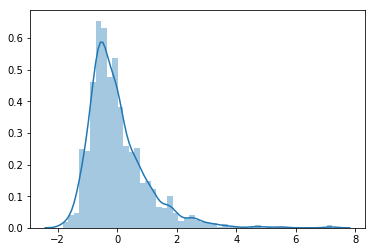

In [7]:
sns.distplot(saleprice_scaled)

In [8]:
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]

In [9]:
high_range, low_range

(array([[ 3.82897043],
        [ 4.04098249],
        [ 4.49634819],
        [ 4.71041276],
        [ 4.73032076],
        [ 5.06214602],
        [ 5.42383959],
        [ 5.59185509],
        [ 7.10289909],
        [ 7.22881942]]), array([[-1.83870376],
        [-1.83352844],
        [-1.80092766],
        [-1.78329881],
        [-1.77448439],
        [-1.62337999],
        [-1.61708398],
        [-1.58560389],
        [-1.58560389],
        [-1.5731    ]]))

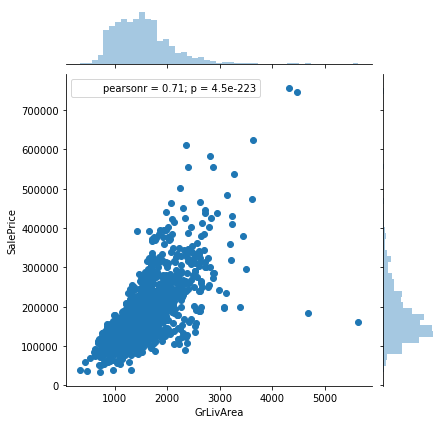

In [10]:
sns.jointplot(y='SalePrice', x='GrLivArea', data=train)

In [11]:
# Delete two outliers at the bottom right corner
idx = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index
train.drop(idx, inplace=True)

# Feature Engineering

**IMPORTANT** note: When you transform (change/delete/add columns) your train data you need to apply the same transformations to your test data. This is because your model will learn to make predictions with the transformed train data. It doesn't know how to handle untransformed data.

In [12]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

### Missing data

In [13]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
len(all_data_na)
missing_data.head(5)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151


Go through all 34 features which have missing values and impute reasonable values.

In [14]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Change some numerical features to categorical features.

In [15]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Encoding of categorical variables

**Label encoding**: Each catgeory is assigned to one number (order adds information)  
**One-hot enconding**: Each cageory ais represented as one separat feature (no specific order; blows up the feature space)

In [16]:
all_data.shape

(2917, 78)

In [17]:
# Order adds information
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    all_data[c] = LabelEncoder().fit_transform(all_data.loc[:,c])

In [18]:
all_data.shape

(2917, 78)

In [19]:
# No order in the different categories
all_data = pd.get_dummies(all_data) # also doable with sklearn.preprocessing.OneHotEncoder but more complicated

In [20]:
all_data.shape # Feature space became quite big

(2917, 219)

### A little bit of feature generation: adding a feature representing the combined area of the building

In [21]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Model building

In [59]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [60]:
train.shape

(1458, 220)

In [88]:
train.to_csv('train_3.csv')
test.to_csv('test_3.csv')

## Cross validation

In [77]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
import math

In [78]:
y_train_log = np.log1p(y_train)

def rmse_cv(model):
    return (np.sqrt(-cross_val_score(model, train.values, y_train_log, scoring="neg_mean_squared_error", cv = 5)))

In [79]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [80]:
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1178 (0.0076)



In [81]:
GBoost.fit(train,y_train_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False)

In [82]:
f_i = GBoost.feature_importances_

In [86]:
feature_importance = pd.DataFrame(data=f_i, index=train.columns)
feature_importance_top_15 = feature_importance.sort_values(by=0).nlargest(15,0)

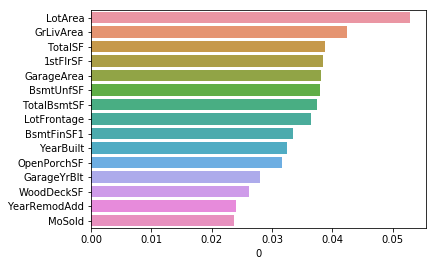

In [87]:
sns.barplot(y=feature_importance_top_15.index,x=feature_importance_top_15.loc[:, 0])

In [ ]:
prediction = GBoost.predict(test)

In [ ]:
prediction = np.exp(prediction)

In [ ]:
prediction = pd.DataFrame(data=prediction, index=test_ID, columns=['SalePrice'])

In [ ]:
prediction.head()

In [ ]:
prediction.to_csv('submission_03.csv')